<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Feature Selection on the Titanic Data Set

_Authors: Joseph Nelson (SF)_

---

In this lab, you'll explore a variety of different feature selection methods in scikit-learn. You'll be using the Titanic data set.

You can load the Titanic data as follows:

    psql -h dsi.c20gkj5cvu3l.us-east-1.rds.amazonaws.com -p 5432 -U dsi_student titanic
    password: gastudents

Or alternatively, load the data set from the local folder:

    ./datasets/titanic_train.csv
    

## Useful Feature Selection Resources

---

- Michigan State Overview on [Feature Selection](http://www.cse.msu.edu/~cse802/Feature_selection.pdf) and (Bonus) Texas A&M on [Bidirectional Feature Selection](http://research.cs.tamu.edu/prism/lectures/pr/pr_l11.pdf)
- Scikit-Learn Documentation on [Feature Selection](http://scikit-learn.org/stable/modules/feature_selection.html)
- Side-by-Side Comparison of [Feature Selection Tactics](http://blog.datadive.net/selecting-good-features-part-iv-stability-selection-rfe-and-everything-side-by-side/)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('fivethirtyeight')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

### 1) Import the data and perform exploratory data analysis (EDA). Engineer any features you think are predictive of survival.

We'll be working with the Titanic data set. Go ahead and import it from the data set folder (or query for it as described above). 

In [2]:
df = pd.read_csv('../datasets/titanic_train.csv')

In [3]:
df.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


In [4]:
df.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [5]:
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [7]:
for item in df:
    print(item, df[item].nunique())

PassengerId 891
Survived 2
Pclass 3
Name 891
Sex 2
Age 88
SibSp 7
Parch 7
Ticket 681
Fare 248
Cabin 147
Embarked 3


In [8]:
# We'll create some dummy-coded columns for which letter was in the cabin and the
# number of the cabin. In the case there are multiple, we'll just use the first.
# If null, just code 0s.
# This is intended to see if features will be eliminated.

In [9]:
cabin_letter = df.Cabin.map(lambda x: 'Z' if pd.isnull(x) else x.split()[0][0])
cabin_letter.unique()

array(['Z', 'C', 'E', 'G', 'D', 'A', 'B', 'F', 'T'], dtype=object)

In [10]:
cabin_dummy = pd.get_dummies(cabin_letter, prefix='cabin')
cabin_dummy.head()

,cabin_A,cabin_B,cabin_C,cabin_D,cabin_E,cabin_F,cabin_G,cabin_T,cabin_Z
0,0,0,0,0,0,0,0,0,1
1,0,0,1,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,1
3,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,1


In [11]:
cabin_dummy.drop('cabin_Z', axis=1, inplace=True)

In [12]:
def cabin_numberer(x):
    try:
        return int(x.split()[0][1:])
    except:
        return 0

cabin_num = df.Cabin.map(cabin_numberer)
cabin_num.unique()

array([  0,  85, 123,  46,   6, 103,  56,  23,  78,  33,  30,  52,  28,
        83,  31,   5,  10,  26, 110,  58, 101,  47,  86,   2,  19,   7,
        49,   4,  32,  80,  36,  15,  93,  35,  87,  77,  67,  94, 125,
        99, 118,  22, 106,  65,  54,  57,  34,  18, 124,  91,  40, 128,
        37,  50,  82,  96,  44, 104, 111,  92,  38,  21,  12,  63,  14,
        20,  79,  25,  73,  95,  39,  70,  16,  68,  41,   9,  48, 126,
        71,  51,  62,  24,  90,  45,   8, 121,  11,   3,  17, 102,  69,
        42, 148])

In [13]:
df['cabin_number'] = cabin_num
df = pd.concat([df, cabin_dummy], axis=1)

In [14]:
# Realistically, a person's name, passenger ID, and ticket number 
# are unlikely to be useful features to us.

In [15]:
# Keep passengerid in for the sake of example.
# Remove name, ticket, and cabin.
df.drop('PassengerId', inplace=True, axis=1)
df.drop('Name', inplace=True, axis=1)
df.drop('Ticket', inplace=True, axis=1)
df.drop('Cabin', inplace=True, axis=1)

In [16]:
# Impute the median for age to fill the nulls.
df.Age.fillna(df.Age.median(), inplace=True)

# The mean and median age values are very close (28 and 29). 
# We can assume our distribution of age is fairly normal.


In [17]:
# Make dummy variables for the embarked column, dropping the original embarked column 
# and 'S' (the most common embarcation point).
df = pd.concat([df, pd.get_dummies(df.Embarked)], axis=1)
df.drop('S', inplace=True, axis=1)
df.drop('Embarked', inplace=True, axis=1)

# You could use drop_first = True, but remember that there's more than one way to do anything.

In [18]:
# Instead of sex, create a column called 'male' with a binary value.
df['Male'] = df.Sex.apply(lambda x: 'female' not in str(x))

# Drop the original sex column.
df.drop('Sex', inplace=True, axis=1)

In [19]:
df.head()
# Data after cleaning and parsing.

,Survived,Pclass,Age,SibSp,Parch,Fare,cabin_number,cabin_A,cabin_B,cabin_C,cabin_D,cabin_E,cabin_F,cabin_G,cabin_T,C,Q,Male
0,0,3,22.0,1,0,7.2500,0,0,0,0,0,0,0,0,0,0,0,True
1,1,1,38.0,1,0,71.2833,85,0,0,1,0,0,0,0,0,1,0,False
2,1,3,26.0,0,0,7.9250,0,0,0,0,0,0,0,0,0,0,0,False
3,1,1,35.0,1,0,53.1000,123,0,0,1,0,0,0,0,0,0,0,False
4,0,3,35.0,0,0,8.0500,0,0,0,0,0,0,0,0,0,0,0,True


### 2) Set Up Predictor and Target Matrices

- The target should be `Survived`.
- The predictor matrix will be all other variables.

In [20]:
# This list of column names will come in handy later.
cols = list(df.columns)
cols.remove('Survived')

X = df[cols]
y = df.Survived.values

### 3) Feature Selection

Let's use the `SelectKBest` method in scikit-learn to see which are the top five features. Also load the `f_classif` and `chi2` functions, which will be our metrics to evaluate what makes a variable the "best."

```python
from sklearn.feature_selection import SelectKBest, f_classif, chi2
```

- What are the top five features for `X` using `f_classif`?
- What are the top five features for `X` using `chi2`?


> The F-test is explained variance divided by unexplained variance. High numbers will result if our explained variance (what we know) is much greater than our unexplained variance (what we don't know). The `chi2` goodness of fit is the sum of the difference squared between observed and expected, divided by expected.

In [21]:
from sklearn.feature_selection import SelectKBest, chi2, f_classif

# Build the selector — we'll build one with each score type.
skb_f = SelectKBest(f_classif, k=5)
skb_chi2 = SelectKBest(chi2, k=5)

# Train the selector on the data.
skb_f.fit(X, y)
skb_chi2.fit(X, y)

# Examine the results.
kbest = pd.DataFrame([cols, list(skb_f.scores_), list(skb_chi2.scores_)], 
                     index=['feature','f_classif','chi2 score']).T.sort_values('f_classif', ascending=False)
kbest

,feature,f_classif,chi2 score
16,Male,372.406,92.7024
0,Pclass,115.031,30.8737
4,Fare,63.0308,4518.32
5,cabin_number,52.1563,3175.49
7,cabin_B,28.1172,25.8756
14,C,25.896,20.4644
9,cabin_D,20.6632,19.4896
10,cabin_E,19.1792,18.1406
8,cabin_C,11.8417,10.9367
3,Parch,5.96346,10.0975


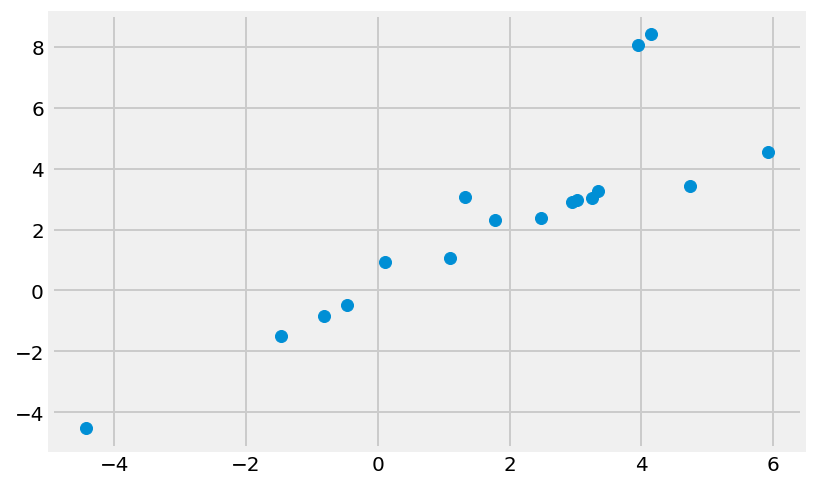

In [22]:
plt.scatter([np.log(x) for x in kbest['f_classif']],
            [np.log(x) for x in kbest['chi2 score']])

### 4) Recursive Feature Elimination (RFE)

Scikit-learn also offers recursive feature elimination as a class named `RFECV`. Use it in combination with a logistic regression model to see what features would be kept with this method.

When instantiating the `RFECV`:
- `step` indicates what percent of features (or number of features if an integer) to remove at each iteration.
- `cv` indicates the number of cross-validation folds to use for evaluating what features are important.

Store the columns in a variable called `rfecv_columns`.

In [24]:
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
selector = RFECV(lr, step=1, cv=10)
selector = selector.fit(X, y)

print(selector.support_)
print(selector.ranking_)

[ True False  True  True False False  True  True  True  True  True  True
  True  True  True  True  True]
[1 2 1 1 4 3 1 1 1 1 1 1 1 1 1 1 1]


In [25]:
# The column names correspond to the ones below. RFECV only excluded a few features.
rfecv_columns = np.array(cols)[selector.support_]
rfecv_columns

array(['Pclass', 'SibSp', 'Parch', 'cabin_A', 'cabin_B', 'cabin_C',
       'cabin_D', 'cabin_E', 'cabin_F', 'cabin_G', 'cabin_T', 'C', 'Q',
       'Male'], dtype='<U12')

### 5) Feature Elimination Using the Lasso Penalty

The L1 penalty is a popular method for feature selection. As the regularization strength increases, more features will be removed.

Load the `LogisticRegressionCV` class.

1) Standardize your predictor matrix (required for regularization).
- Create a logistic regression cross-validator object:
    - Set `penalty='l1'` (lasso).
    - Set `Cs=100` (search 100 different regularization strengths).
    - Set `solver='liblinear'` (required for the lasso penalty).
    - Set `cv=10` for 10 cross-validation folds.
- Fit on the target and standardized predictors.
- Sort the logistic regression coefficients by absolute value. 

Do the top five correspond to those selected by the F-score and `chi2`?


> Answer: *Not completely. That could be because of scaling.
> Some features are going to perform better based on the model type, and if we hadn't regularized, some could be perceived as much more significant than they are.*

Choose which ones you would keep and store them in a variable called `lr_columns`.

In [26]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
Xs = ss.fit_transform(X)

In [27]:
from sklearn.linear_model import LogisticRegressionCV

lrcv = LogisticRegressionCV(penalty='l1', Cs=100, cv=10, solver='liblinear')
lrcv.fit(Xs, y)

LogisticRegressionCV(Cs=100, class_weight=None, cv=10, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
           refit=True, scoring=None, solver='liblinear', tol=0.0001,
           verbose=0)

In [28]:
lrcv.C_

array([0.08111308])

In [29]:
# What are the best coefficients according to a model using lasso?
coeffs = pd.DataFrame(lrcv.coef_, columns=X.columns)
coeffs_t = coeffs.transpose()
coeffs_t.columns = ['lasso_coefs']
coeffs_abs = coeffs_t.abs().sort_values('lasso_coefs', ascending=False)
coeffs_abs

,lasso_coefs
Male,1.140583
Pclass,0.665795
Age,0.315406
SibSp,0.197771
cabin_E,0.147660
C,0.104238
cabin_D,0.081645
cabin_F,0.064450
Fare,0.036154
cabin_B,0.023164


In [30]:
# A few variables were eliminated. It's not totally consistent with RFECV — 
# more features were eliminated by the lasso method.

### 6) Compare Features Sets

Use the optimized logistic regression from the previous question on the features selected from different methods. 
- `kbest_columns`
- `rfecv_columns`
- `lasso_columns`
- `all_columns`

**Questions:**
- Which scores the highest? (Use cross_val_score.)
- Is the difference significant?


In [31]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

In [32]:
kbest_columns = kbest.feature.values[0:5]
lasso_columns = coeffs_abs.index[coeffs_t.lasso_coefs != 0]

In [33]:
lr = LogisticRegression(C=lrcv.C_[0], penalty='l1', solver='liblinear')

# Defining a function to test our best features head to head.
def score(X):
    scores = cross_val_score(lr, X, y, cv=5)
    return scores.mean(), scores.std()

# A list of all of our lists of best features being executed in the score function.
all_scores = [
    score(X[kbest_columns]),
    score(X[rfecv_columns]),
    score(X[lasso_columns]),
    score(X)]

# Putting results into a DataFrame.
pd.DataFrame(all_scores, columns=['mean score', 'std score'], index = ['kbest', 'rfecv', 'lr', 'all'])

,mean score,std score
kbest,0.776691,0.019541
rfecv,0.787832,0.020027
lr,0.780055,0.019567
all,0.781166,0.020190


In [34]:
# There is very little difference in the performance 
# of different features for this data set.

### 7) [Bonus] Display the lasso logistic regression coefficients with a bar chart

Start from the most negative on the left.

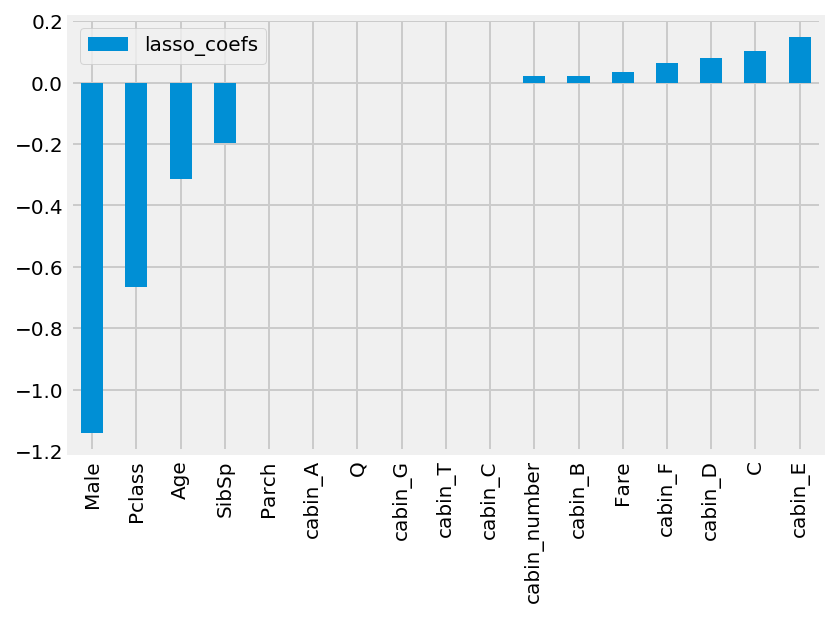

In [35]:
coeffs_t.sort_values('lasso_coefs').plot(kind='bar')
